In [1]:
import numpy as np
import pandas as pd
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess

from torchvision import transforms, models

In [2]:
SEED = 18
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alifrahman/chestxraydataset")



In [15]:
for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join("datasets", item)

    if os.path.isdir(source):
        shutil.move(source, destination)
    else:
        shutil.move(source, destination)

print("Dataset moved to current folder.")

Dataset moved to current folder.


In [18]:
data_root = 'datasets/chest_xray'
print(os.listdir(data_root))

['test', 'train']


In [21]:
train_dir = 'datasets/pneumonia/train'
val_dir = 'datasets/pneumonia/val'
each_val_img_ind = 50

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

class_names = ['NORMAL', 'PNEUMONIA']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
    os.makedirs(os.path.join(dir_name, 'virus'), exist_ok=True)  # Создаем папку virus

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if 'virus' in file_name:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, 'virus')
            else:
                dest_dir = os.path.join(val_dir, 'virus')
        else:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, class_name)
            else:
                dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
class_names.append('virus')

100%|██████████| 3875/3875 [00:01<00:00, 2713.16it/s]


In [ ]:
train_transforms = [
    transforms.Compose([
    transforms.Resize((224,224)),   
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.CenterCrop(200),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),          
]

val_transforms = [transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),]

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,train_transform)
                                                    for train_transform in val_transforms])

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir,train_transform)
                                                    for train_transform in val_transforms])

# train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms=val_transforms)
# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [23]:
print("train size : {} val size : {}".format(len(train_dataloader), len(val_dataloader)))

train size : 512 val size : 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9882353720664978].


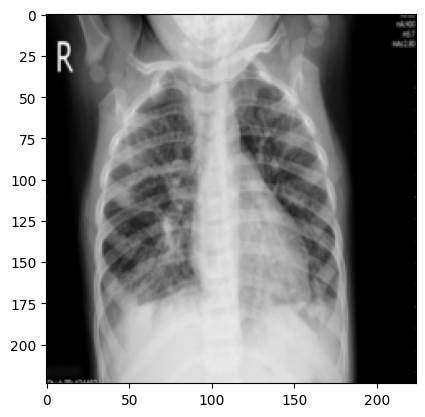

In [24]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

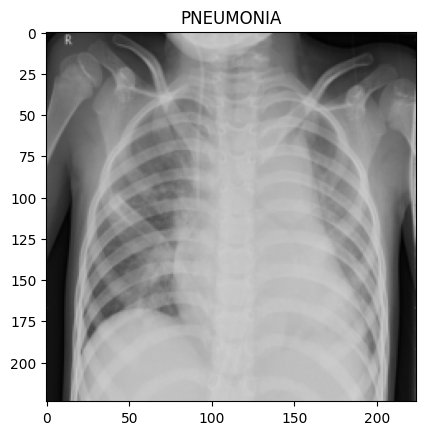

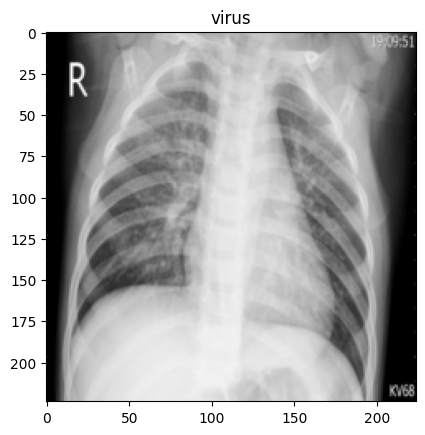

In [27]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch[:2], y_batch[:2]):
    show_input(x_item, title=class_names[y_item])

In [ ]:
class CustomNeuralNetResNet(torch.nn.Module):
    def __init__(self,outputs_number):
        super(CustomNeuralNetResNet, self).__init__()
#         self.net = models.resnet18(pretrained=False)
        self.net = models.resnet50(pretrained=False)
        
#         self.net = models.resnet101(pretrained=True)
        
#         for param in self.net.parameters():
#             param.requires_grad = False

#         TransferModelOutputs = self.net.fc.in_features
#         self.net.fc = torch.nn.Sequential(
#             torch.nn.Linear(TransferModelOutputs, outputs_number))
#         

    def forward(self, x):
        return self.net(x)

In [29]:
model = CustomNeuralNetResNet(3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
# loss = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True) # смотреть предыдущие градиенты для лучшей сходимости
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.2)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/home/kayc/Code/MediScan/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kayc/Code/MediScan/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_weights = None
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
#                     log_probs = torch.nn.functional.log_softmax(preds, dim=1)
#                     loss_value = loss(log_probs, labels)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_val_acc =  epoch_acc
                    best_model_weights = model.state_dict()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    if best_model_weights is not None:
        model_path = "saved_models/best_model.pth"
        os.makedirs(model_path,exist_ok=True)
        torch.save(best_model_weights, model_path)
        print('Best model saved with loss:', best_val_loss, best_val_acc)

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/0:


100%|██████████| 512/512 [00:36<00:00, 14.13it/s]

train Loss: 0.4304 Acc: 0.8102



100%|██████████| 11/11 [00:00<00:00, 13.65it/s]

val Loss: 0.5226 Acc: 0.7818


Best model saved with loss: 0.5225747234442017 tensor(0.7818, device='cuda:0')


In [33]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

In [34]:
train_loss_list = list()
val_loss_list = list()
train_acc_list = list()
val_acc_list = list()

In [35]:
train_loss_list.append(train_loss.numpy())
val_loss_list.append(val_loss.numpy())
train_acc_list.append(train_acc.numpy())
val_acc_list.append(val_acc.numpy())

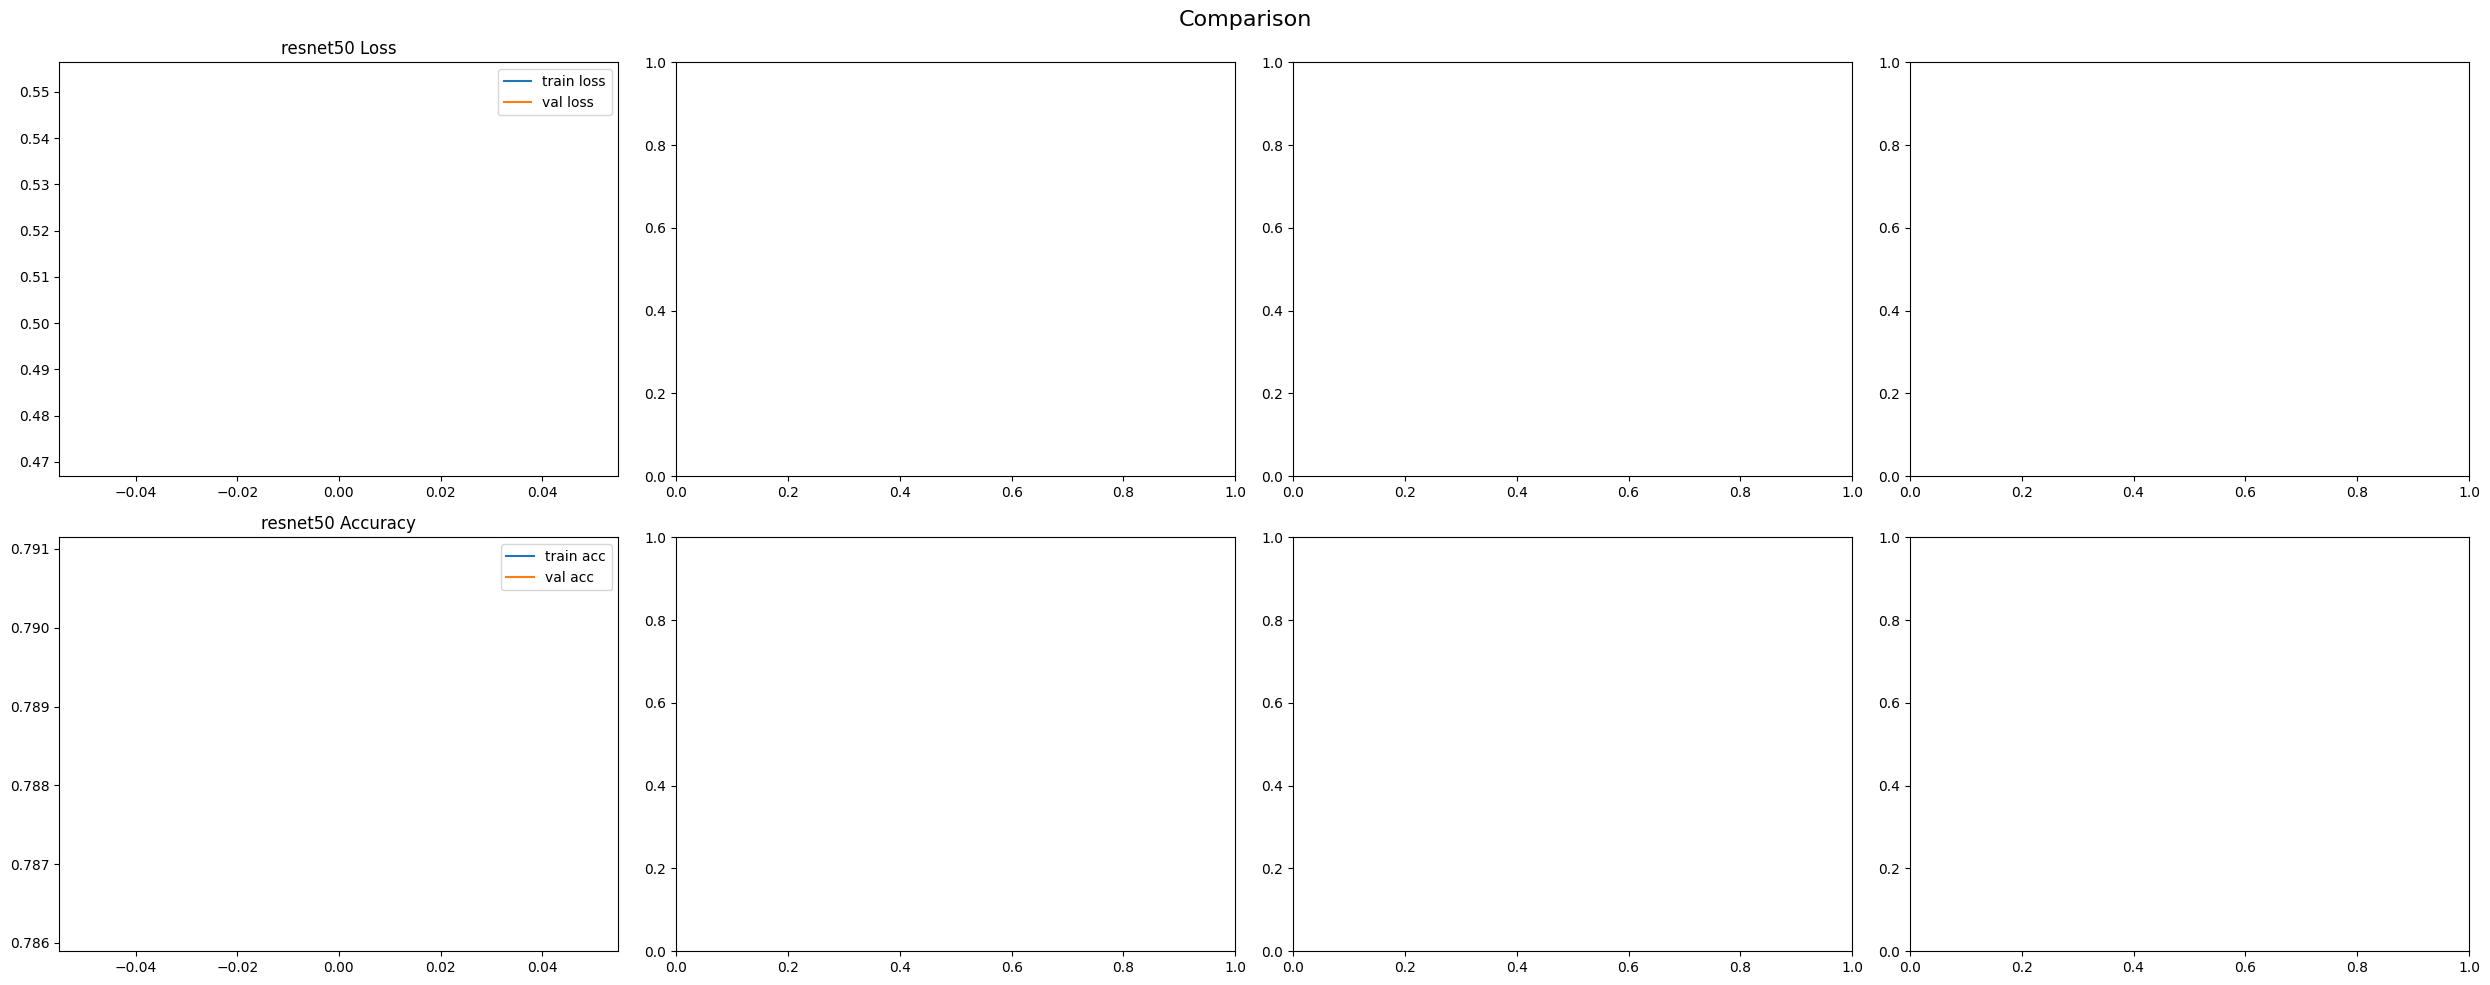

In [37]:
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
# title = ['NLLLoss + SGD', 'NLLLoss + Adam', 'CrossEntropyLoss + SGD', 'CrossEntropyLoss + Adam']
title = ['resnet50', 'resnet50 pret', 'resnet101 pret', 'resnet101 pret']


for i in range(1):
    axs[0][i].plot(train_loss_list[i], label='train loss')
    axs[0][i].plot(val_loss_list[i], label='val loss')
    axs[0][i].set_title(f'{title[i]} Loss')
    axs[0][i].legend(loc='best')
    
    axs[1][i].plot(train_acc_list[i], label='train acc')
    axs[1][i].plot(val_acc_list[i], label='val acc')
    axs[1][i].set_title(f'{title[i]} Accuracy')
    axs[1][i].legend(loc='best')

fig.suptitle('Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [38]:
train_loss = train_loss.numpy()
val_loss = val_loss.numpy()
train_acc = train_acc.numpy()
val_acc = val_acc.numpy()

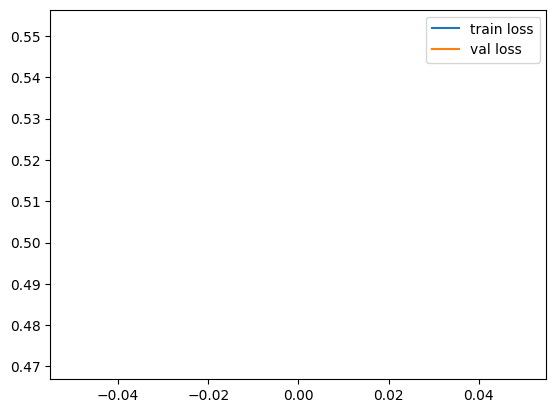

In [39]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc='best')
plt.show()

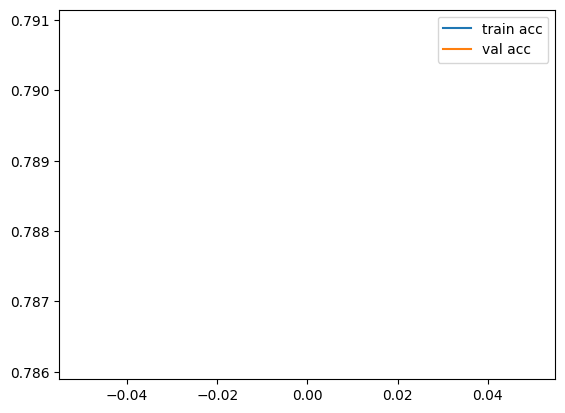

In [40]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'val acc')
plt.legend(loc='best')
plt.show()

100%|██████████| 11/11 [00:00<00:00, 11.97it/s]


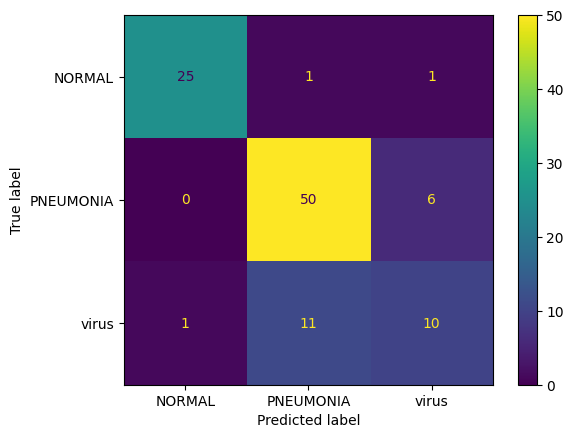

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

all_labels, all_preds = evaluate_model(model, val_dataloader)
plot_confusion_matrix(all_labels, all_preds, class_names)

In [43]:
data_root = 'datasets/chest_xray/test'
test_dir = 'datasets/pneumonia/test'
shutil.copytree(data_root, test_dir)

'datasets/pneumonia/test'

In [45]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_data = 'datasets/pneumonia/test'
test_dataset = ImageFolderWithPaths(test_data, val_transforms[0])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
def get_predictions(dataloader):
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(dataloader):
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        preds = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
        test_predictions.append(preds)
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)
    return test_predictions, test_img_paths

test_predictions, test_img_paths = get_predictions(test_dataloader)

100%|██████████| 63/63 [00:08<00:00,  7.60it/s]


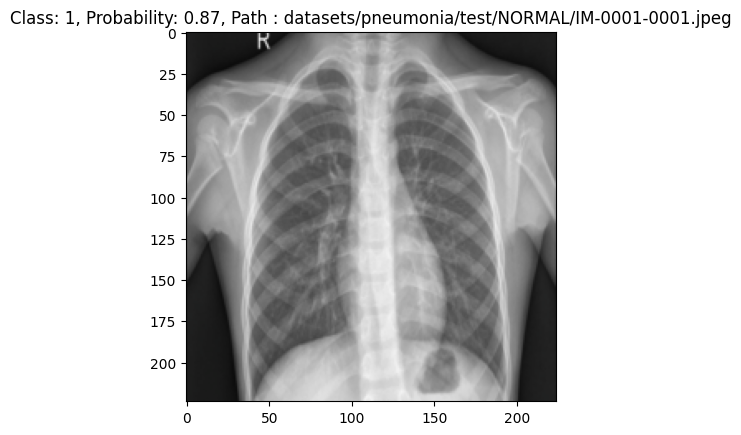

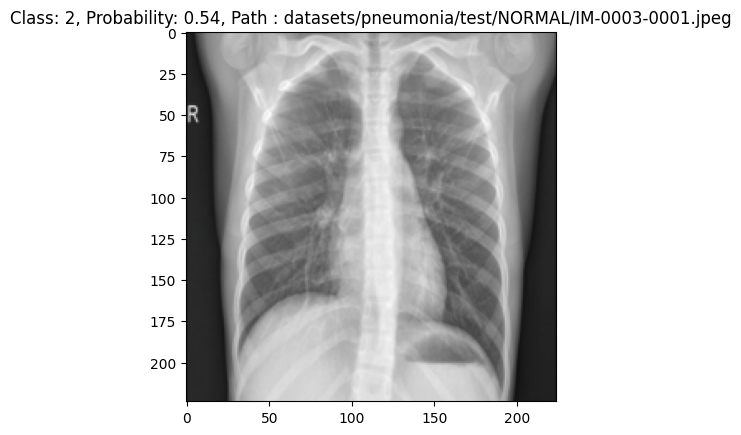

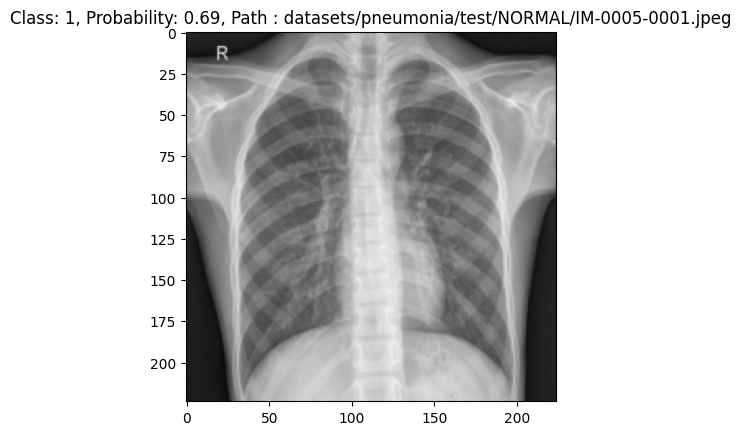

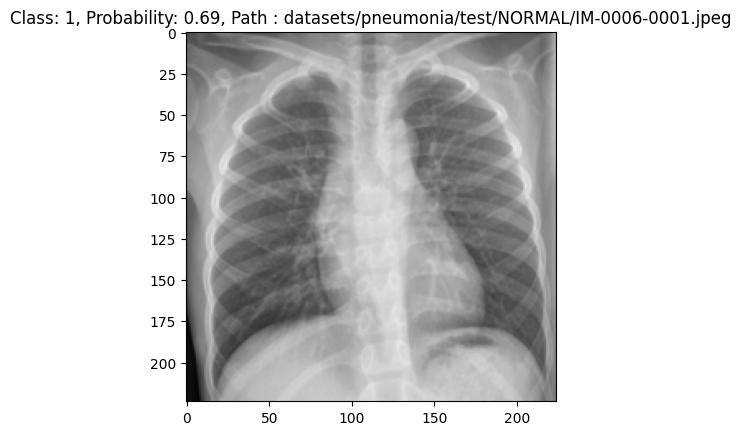

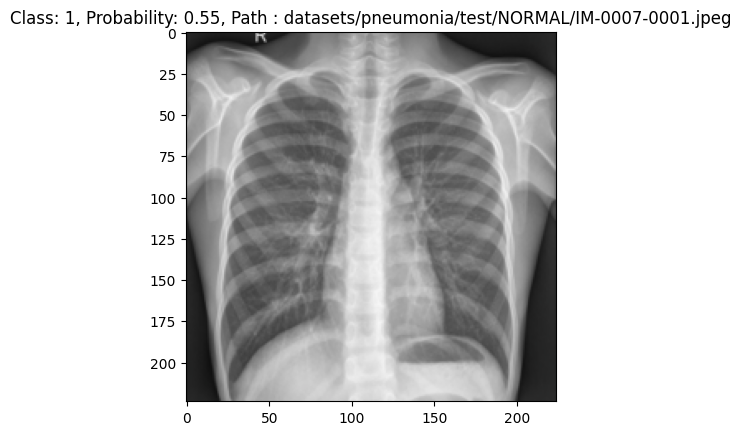

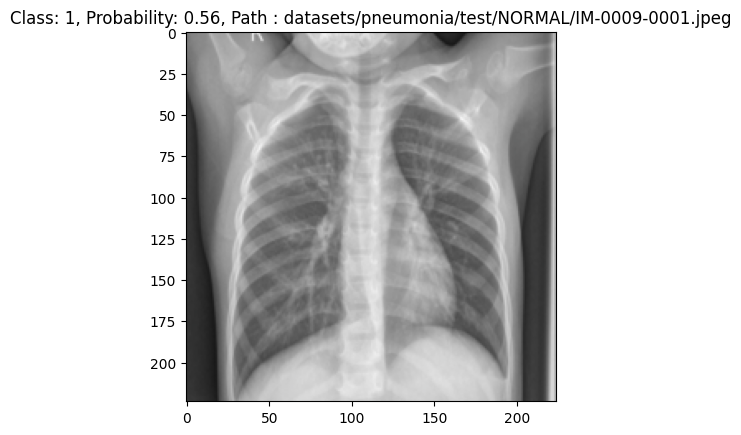

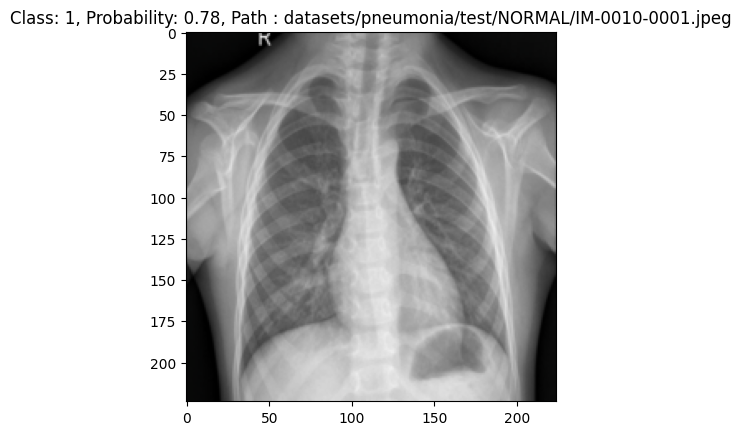

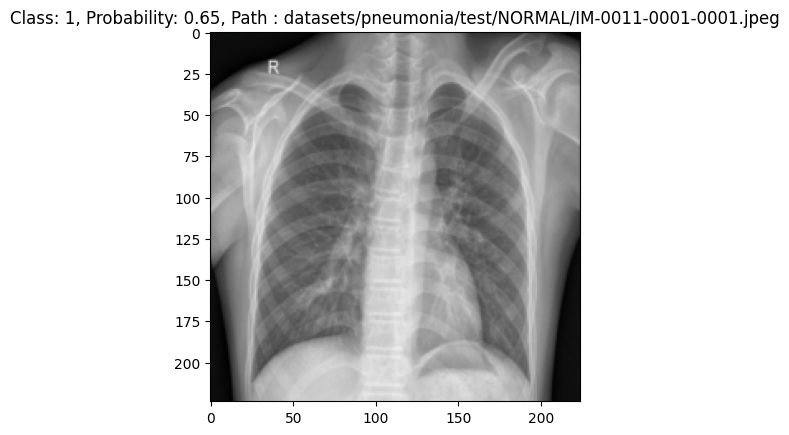

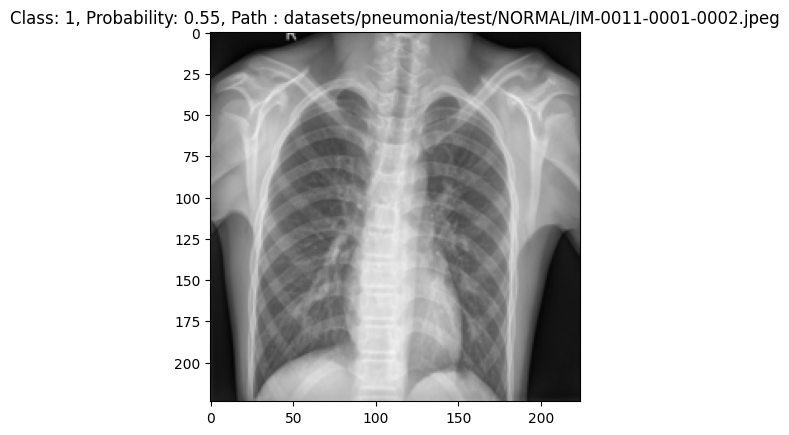

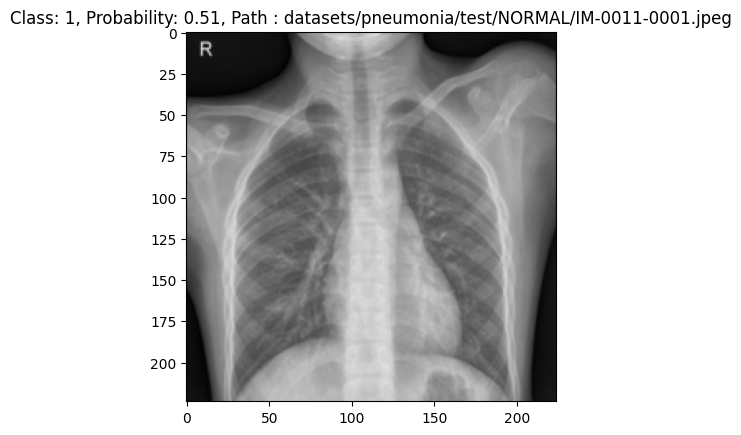

In [47]:
n_images = 1
iter_obj = iter(test_dataloader)

for _ in range(n_images):
    inputs, labels, paths = next(iter_obj)
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    for i, (img, pred) in enumerate(zip(inputs, preds)):
        pred = torch.nn.functional.softmax(pred, dim=0).data.cpu().numpy()
        img = img.cpu()
        predicted_class = np.argmax(pred)
        probability = pred[predicted_class]
        
        title = f'Class: {predicted_class}, Probability: {probability:.2f}, Path : {paths[i]}'
        show_input(img, title=title)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: ylabel='Count'>

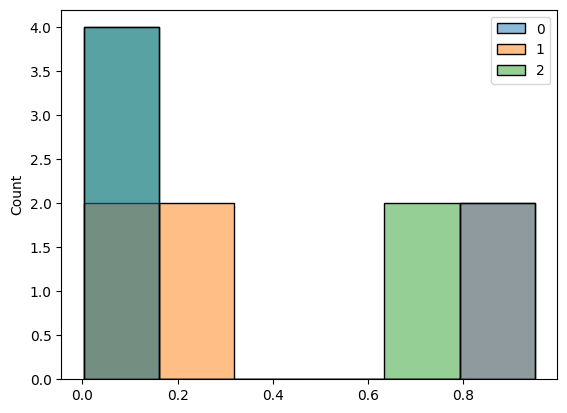

In [128]:
sns.histplot(test_predictions)

/tmp/ipykernel_34/605361181.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred).data.cpu().numpy()


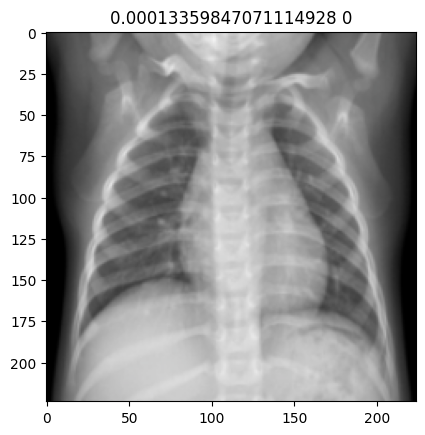

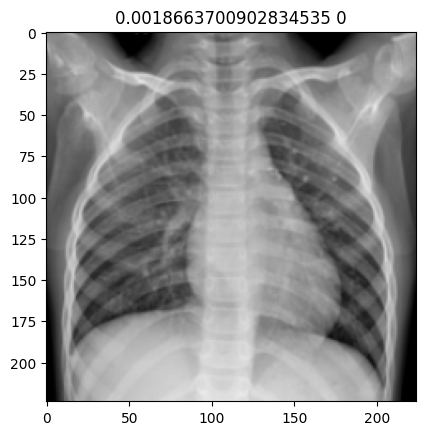

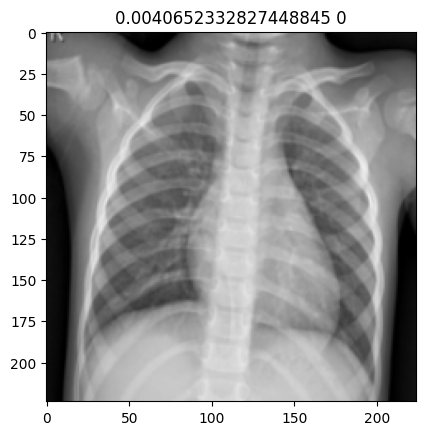

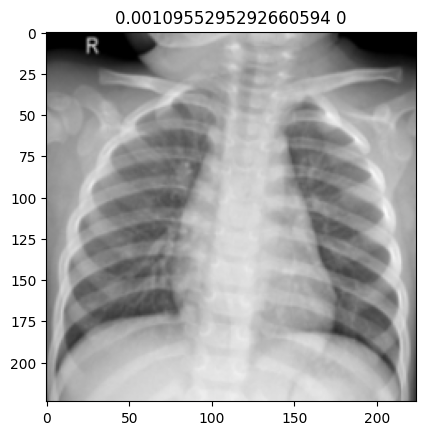

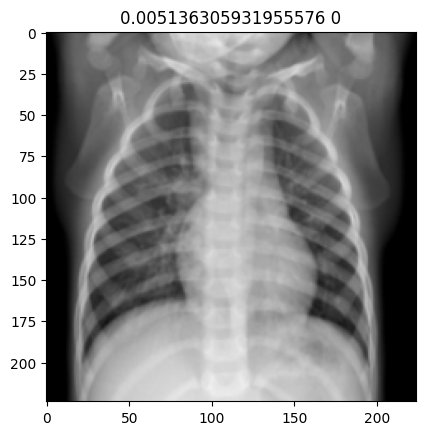

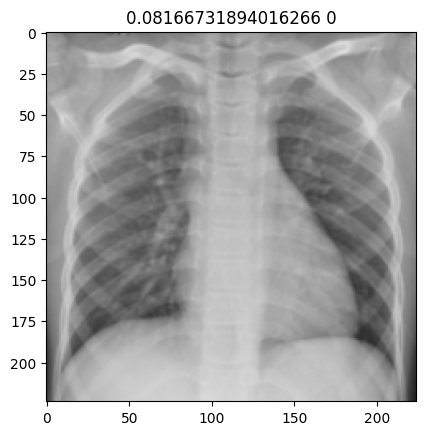

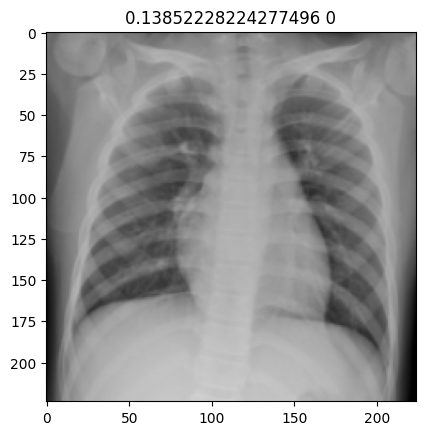

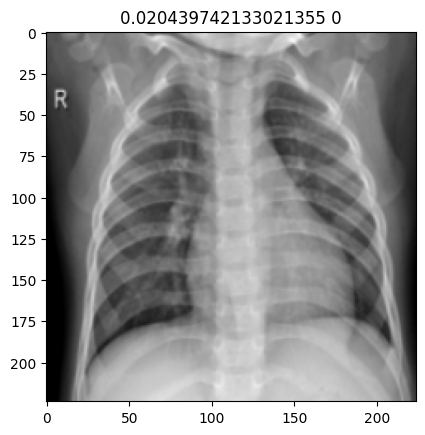

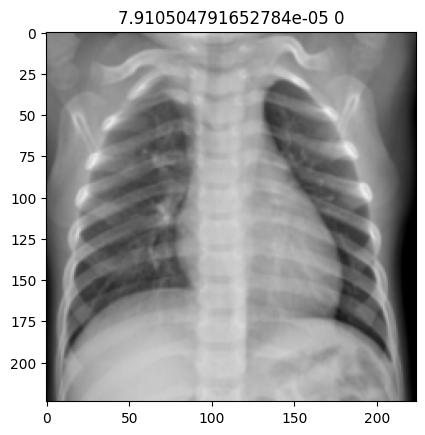

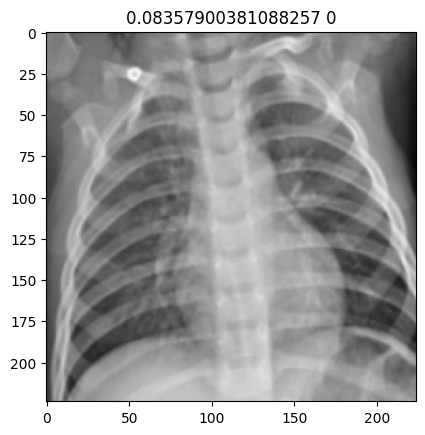

In [131]:
n_images = 1
iter_obj = iter(val_dataloader)

# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

dirty_probs = []
clean_probs = []

for _ in range(n_images):
    X_batch, y_batch = next(iter(iter_obj))
    X_batch = X_batch.to(device)
    with torch.set_grad_enabled(False):
        preds = model(X_batch)
    for img, pred_label in zip(X_batch, zip(preds, y_batch)):
            pred, label = pred_label
            pred = torch.nn.functional.softmax(pred).data.cpu().numpy()
            pred = pred[1]
            img = img.cpu()
            show_input(img, title="{} {}".format(pred, label))